In [2]:
# 在这个代码段中，我们首先导入所需的库和模块
# 通过%matplotlib inline将matplotlib设置为嵌入式显示图像
# zuko模块的来源未知，可能是自定义模块或第三方模块

import matplotlib.pyplot as plt  # 导入matplotlib库用于绘图
import torch  # 导入PyTorch库
import torch.nn as nn  # 导入PyTorch中的神经网络模块
import torch.optim as optim  # 导入PyTorch中的优化器模块
import torch.nn.utils as nn_utils  # 导入PyTorch中的神经网络工具模块
import zuko  # 导入zuko模块
from torch.optim import lr_scheduler  # 从PyTorch中的优化器模块中导入学习率调整器

from itertools import islice  # 导入itertools模块中的islice函数
from tqdm import tqdm  # 导入tqdm模块中的tqdm函数，用于循环迭代时添加进度条

from lampe.data import JointLoader  # 从lampe.data模块中导入JointLoader类
from lampe.inference import NPE, NPELoss  # 从lampe.inference模块中导入NPE和NPELoss类
from lampe.plots import nice_rc, corner, mark_point  # 从lampe.plots模块中导入nice_rc、corner和mart_point函数
from lampe.utils import GDStep  # 从lampe.utils模块中导入GDStep类
from lampe.data import H5Dataset  # 从lampe.data模块中导入H5Dataset类
from lampe.diagnostics import expected_coverage_mc  # 从lampe.diagnostics模块中导入expected_coverage_mc函数

import h5py  # 导入h5py库，用于处理HDF5格式的数据
import numpy as np  # 导入NumPy库，用于支持大量的维度数组与矩阵运算
from datetime import datetime  # 从datetime模块中导入datetime类
import gc  # 导入gc（垃圾回收）模块

/home/opt/python/anaconda3.8_TF2.5/envs/torch_1.12.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 训练

In [3]:
data_set_dir='/home/lichunyue/sty/train_p/'

#固定的参数

LOWER = torch.tensor([0  ,  0. ])
UPPER = torch.tensor([0.2 , 1. ])

#参数归一化与逆运算
def preprocess(theta: torch.Tensor) -> torch.Tensor:
    return 2 * (theta - LOWER) / (UPPER - LOWER) - 1

def postprocess(theta: torch.Tensor) -> torch.Tensor:
    return (theta + 1) / 2 * (UPPER - LOWER) + LOWER


In [ ]:
def add(a: int, b: int) -> int:
    return a + b
print(add(1,2))

In [ ]:
#  "act<class 'torch.nn.modules.activation.ReLU'>学习率0.0003,正则化0.001,休眠率0.2,参数数目1024,参数层数7,流层9,中间层256,最佳损失-5.820067882537842,训练周期28",
#"act<class 'torch.nn.modules.activation.ReLU'>学习率0.0003,正则化0,休眠率0.2,参数数目1024,参数层数7,流层9,中间层512,最佳损失-3.325531482696533,训练周期35",
# 1
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。
for act in [nn.ReLU]:# 激活函数是relu
  for f in [0.0001]:# 学习率是0.0001
    for weight_decay in [0]:# 正则化参数, 这里被设置为0意味着模型不使用L2正则化
       for liu in [zuko.flows.NSF]: # 标准化流
        for transfomr in [5]:#特征提取的blocks的数量, 意味着模型中将有5个特征提取的块或层
         for num in [4096]: # 4096是什么来着...
          for trans in [13]:#NF的残差块--画图的 # 残差块的数量? 怎么计数的?
           for beishu in [1024]: # 某个维度的乘数, 不好说
            # 获取当前时间
            now= datetime.now()
            
            # 修复批量归一化层
            def fix_bn(m):
                classname = m.__class__.__name__
                if classname.find('BatchNorm') != -1:
                    m.eval()
            
            # 权重初始化
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            # 定义名为Bottleneck的神经网络模块
            class Bottleneck(torch.nn.Module):
                # 初始化函数，定义模块的输入通道数、中间通道数、输出通道数和是否下采样
                def __init__(self, In_channel, Med_channel, Out_channel, downsample=False):
                    super(Bottleneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    # 使用Sequential容器封装多个网络层，依次进行前向传播
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),  # 1x1卷积层，用于降维
                        torch.nn.BatchNorm1d(Med_channel),  # 批标准化层，用于加速训练过程
                        torch.nn.ReLU(),  # ReLU激活函数，引入非线性因素
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),  # 3x3卷积层，保持特征图大小不变
                        torch.nn.BatchNorm1d(Med_channel),  # 批标准化层，用于加速训练过程
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),  # 1x1卷积层，用于升维
                        torch.nn.BatchNorm1d(Out_channel),  # 批标准化层，用于加速训练过程
                    )

                class NPE(torch.nn.Module):
                    # 定义名为NPE的神经网络模块
                    def __init__(self, In_channel, Out_channel, stride=1):
                        # 初始化函数，接受输入通道数、输出通道数和步长作为参数
                        super(NPE, self).__init__()
                        # 调用父类的初始化函数
                        if In_channel != Out_channel:
                            # 如果输入通道数不等于输出通道数
                            self.res_layer = torch.nn.Conv1d(In_channel, Out_channel, 1, stride)
                            # 则定义一个卷积层res_layer，将输入通道数转换为输出通道数
                        else:
                            # 否则
                            self.res_layer = None
                            # res_layer为空
                        self.jia_relu = torch.nn.Sequential(torch.nn.ReLU())
                        # 定义激活函数为ReLU的序列模块jia_relu
                
                    def forward(self, x):
                        # 前向传播函数，接受输入x
                        if self.res_layer is not None:
                            # 如果res_layer不为空
                            residual = self.res_layer(x)
                            # 则使用res_layer对输入x进行处理得到残差residual
                        else:
                            # 否则
                            residual = x
                            # 残差为输入x
                        return self.jia_relu(self.layer(x) + residual)
                        # 返回激活函数为ReLU的self.layer(x)与residual的和经过激活函数jia_relu处理后的结果
                
                    def forward(self, x):
                        # 再次定义了前向传播函数，接受输入x
                        if self.res_layer is not None:
                            # 如果res_layer不为空
                            residual = self.res_layer(x)
                            # 则使用res_layer对输入x进行处理得到残差residual
                        else:
                            # 否则
                            residual = x
                            # 残差为输入x
                        return self.layer(x) + residual
                        # 返回self.layer(x)与residual的和作为输出

            # 定义 ResNet 类，继承自 torch.nn.Module
            class ResNet(torch.nn.Module):
                # 初始化方法，接收输入通道数和类别数，默认值分别为 1 和 5
                def __init__(self,in_channels=1,classes=5):
                    # 调用父类的初始化方法
                    super(ResNet, self).__init__()
                    # 定义网络的特征提取部分
                    self.features = torch.nn.Sequential(
                        # 第一层卷积
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        # 第一层最大池化
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4
            
                        # Bottleneck 残差模块 1
                        Bottlrneck(64,64,256,False),
                        # Bottleneck 残差模块 2
                        Bottlrneck(256,64,256,False),
                        # Bottleneck 残差模块 3
                        Bottlrneck(256,64,256,False),#256*x/4*x/4
            
                        # Bottleneck 残差模块 4
                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        # Bottleneck 残差模块 5
                        Bottlrneck(512,128,512, False),
                        # Bottleneck 残差模块 6
                        Bottlrneck(512,128,512, False),
                        # Bottleneck 残差模块 7
                        Bottlrneck(512,128,512, False),
            
                        # Bottleneck 残差模块 8
                        Bottlrneck(512,256,1024, True),
                        # Bottleneck 残差模块 9
                        Bottlrneck(1024,256,1024, False),
                        # Bottleneck 残差模块 10
                        Bottlrneck(1024,256,1024, False),
                        # Bottleneck 残差模块 11
                        Bottlrneck(1024,256,1024, False),
                        # Bottleneck 残差模块 12
                        Bottlrneck(1024,256,1024, False),
                        # Bottleneck 残差模块 13
                        Bottlrneck(1024,256,1024, False),
            
                        # Bottleneck 残差模块 14
                        Bottlrneck(1024,512,2048, True),
                        # Bottleneck 残差模块 15
                        Bottlrneck(2048,512,2048, False),
                        # Bottleneck 残差模块 16
                        Bottlrneck(2048,512,2048, False),
            
                        # 自适应平均池化
                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    # 定义分类器部分
                    self.classifer = torch.nn.Sequential(
                        # 全连接层，将2048维特征映射到类别数维
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x

            class NPEWithEmbedding(nn.Module):#这个网络只要是1维的2的倍数就行
                def __init__(self,channels=3,beishu=4,canshu=2,build=zuko.flows.NSF,hidden_features=[128] * 3,activation=nn.ELU,transforms=3):
                    super().__init__()

                    self.npe = NPE(canshu, beishu, build=build, hidden_features=hidden_features,transforms=transforms, activation=activation)#用于
                    self.embedding = ResNet(in_channels=channels,classes=beishu)

                def forward(self, theta: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
                    #print(self.embedding(x).shape)

                    return self.npe(theta, self.embedding(x))

                def flow(self, x: torch.Tensor):  # -> flow对应原来的采样，因为他调用的就是flow
                    return self.npe.flow(self.embedding(x))
                

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            
            estimator_NPE= NPEWithEmbedding(channels=4,canshu=2,beishu=beishu,build=liu,hidden_features=[num] * transfomr,transforms=trans,activation=act).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            estimator_NPE.apply(weight_init);
            optimizer = optim.AdamW(estimator_NPE.parameters(), lr=f,weight_decay=weight_decay)#学习率！！！！！！！！！！！
            #在优化器选项里添加正则化,weight_decay=0.01，l2正则化

            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)#学习率衰减
            #https://zhuanlan.zhihu.com/p/363338422

            # 定义一个梯度下降步骤，带有梯度裁剪的优化器
            step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping,有了他不用optimizer.step
            # 定义一个NPE损失函数
            loss = NPELoss(estimator_NPE)
            
            list_los=[]
            list_losvail=[]
            
            # 使用tqdm实现进度条，迭代2000次，单位是epoch
            with tqdm(range(2000), unit='epoch') as tq:#epoch
                best_loss = np.inf#早停
                best_model_weights = None
                patience=30#10个周期不降就停
                i_all=0
                num=10000#总数
                num_v=2000
                datast=20#batch_size
                nnum=num//datast
                nnum_v=num_v//datast
                
                # 遍历每个epoch
                for epoch in tq:
                    # 优化器梯度清零
                    optimizer.zero_grad()
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    # 加载训练数据和验证数据
                    all_x = torch.tensor(np.load(data_set_dir+f'train_x_{i_all}.npy'),dtype=torch.float32)
                    all_y = torch.tensor(np.load(data_set_dir+f'train_can_{i_all}.npy'),dtype=torch.float32)
            
                    all_x_vail = torch.tensor(np.load(data_set_dir+f'vail_x_{i_all}.npy'),dtype=torch.float32)
                    all_y_vail = torch.tensor(np.load(data_set_dir+f'vail_can_{i_all}.npy'),dtype=torch.float32)
            
                    i_all+=1
                    if i_all>=400:
                        i_all=0
            
                    # 设置estimator_NPE为训练模式
                    estimator_NPE.train()
                    # 计算损失，对每个样本进行梯度下降步骤
                    losses = torch.stack([
                        step(loss(preprocess(all_y[i]).cuda(), all_x[i].cuda()))
                        for i in range(nnum) # 这样写是遍历全部元素，实例那样是因为他是采样器
                    ])
                    
                    # 删除变量以释放内存
                    del all_x, all_y
                    
                    # 将估计器设置为评估模式
                    estimator_NPE.eval()
                    
                    # 使用无梯度计算上下文，计算验证集的损失
                    with torch.no_grad():
                        val_losses = torch.stack([
                            loss(preprocess(all_y_vail[i]).cuda(), all_x_vail[i].cuda())
                            for i in range(nnum_v)
                        ])
                    
                    # 更新学习率调度器
                    scheduler.step()
                    
                    # 使用tq库更新输出的损失信息
                    tq.set_postfix(loss=losses.mean().item(), val_loss=val_losses.mean().item())
                    
                    # 删除变量以释放内存
                    del all_x_vail, all_y_vail
                    
                    # 重命名变量，修正类型不一致的问题
                    los = losses.mean().item() 
                    losval = val_losses.mean().item()
                    
                    # 将损失值添加到列表中，用于绘制损失函数图
                    list_los.append(los)
                    list_losvail.append(losval)
                    
                    # 存储监视数据
                    data1 = list_los
                    data2 = list_losvail
                    last = now
                    now = datetime.now()
                    
                    # 将监视数据写入文件
                    file = open('NPE_p.txt', 'w')
                    file.write('last_last:' + str(last) + '\n')
                    file.write('___last__:' + str(now) + '\n')
                    for item1, item2 in zip(data1, data2):
                        file.write(str(item1) + ' ' + str(item2) + '\n')
                    file.close()
                    
                    # 删除变量以释放内存
                    del losses, data1, data2
                    
                    # 如果验证集的损失值比最佳损失值小，则更新最佳损失值和模型权重
                    if losval < best_loss:
                        best_loss = losval
                        epochs_without_improvement = 0
                        best_model_weights = estimator_NPE.state_dict()
                    else:
                        epochs_without_improvement += 1
                    
                    # 如果连续 patience 个 epoch 验证集的损失值没有改善，则提前停止训练
                    if epochs_without_improvement == patience:
                        estimator_NPE.load_state_dict(best_model_weights)
                        print('Early stopping at epoch {}...'.format(epoch - patience + 1))
                        break

  1%|          | 22/2000 [1:49:17<165:04:56, 300.45s/epoch, loss=-2.57, val_loss=-3.15]

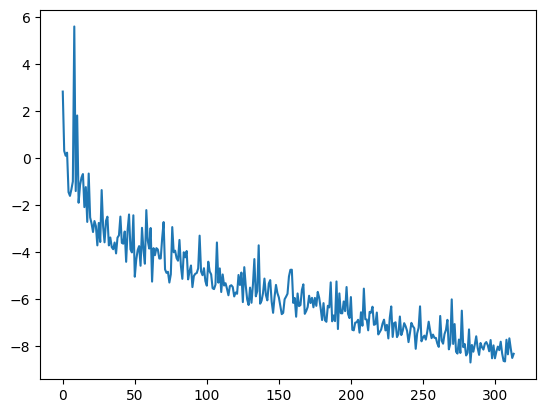

In [13]:
plt.plot(list_losvail)

In [ ]:
#estimator_NPE.load_state_dict(torch.load("/home/DATA/suntianyang/gw_len/net/net/NPE_mid_t_lens.pth"))
#for act in [nn.ReLU]:
#  for f in [0.0001]:
#    for weight_decay in [0]:
#       for liu in [zuko.flows.NSF]:
#        for transfomr in [7]:#特征提取的blocks
#         for num in [4096]:
#          for trans in [9]:#NF的残差块--画图的
#           for beishu in [2048]:

In [12]:
# 2
#非采样器的
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。

aaaaa=[]

import gc

# 对权重进行初始化的函数
def weight_init(m):
    if isinstance(m, (nn.Conv1d, nn.Linear)):  # 如果是一维卷积或全连接层
        nn.init.xavier_uniform_(m.weight.data)  # 使用xavier_uniform_方法初始化权重
        nn.init.constant_(m.bias.data, 0.0)  # 将偏置项初始化为零

# 下面是一组循环，用于设置不同的参数组合
for act in [nn.ReLU]:  # 遍历激活函数列表
    for f in [0.0001]:  # 遍历f参数列表
        for weight_decay in [0]:  # 遍历weight_decay参数列表
            for liu in [zuko.flows.NSF]:  # 遍历liu参数列表
                for transfomr in [7]:  # 特征提取的blocks
                    for num in [4096]:  # 遍历num参数列表
                        for trans in [9]:  # NF的残差块--画图的
                            for beishu in [2048]:  # 遍历beishu参数列表
                                now = datetime.now()  # 获取当前时间
################################################################
            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x

                    return self.jia_relu(self.layer(x)+residual)

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            model= ResNet(in_channels=2,classes=1).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            model.apply(weight_init)
            
            optimizer = optim.AdamW(model.parameters(), lr=f,weight_decay=weight_decay)#学习率！！！！！！！！！！！
            #在优化器选项里添加正则化,weight_decay=0.01，l2正则化

            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)#学习率衰减
            #https://zhuanlan.zhihu.com/p/363338422

            step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping,有了他不用optimizer.step
            loss = nn.BCEWithLogitsLoss()

            list_los=[]
            list_losvail=[]

            with tqdm(range(2000), unit='epoch') as tq:#epoch
                best_loss = np.inf#早停
                best_model_weights = None
                patience=30#10个周期不降就停
                i_all=0
                num=10000#总数
                num_v=2000
                datast=20#batch_size
                nnum=num//datast
                nnum_v=num_v//datast
                
                for epoch in tq:
                    optimizer.zero_grad()
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    all_x = torch.tensor(np.load(data_set_dir+f'train_x_{i_all}.npy'),dtype=torch.float32).reshape(num,4,40960)
                    all_x=get_wave_plus_gaosnoise_t_gen_cai_NPE(all_x).reshape(nnum,datast,2,2**5)
                    all_y = torch.tensor(np.load(data_set_dir+f'train_y_{i_all}.npy'),dtype=torch.float32)

                    all_x_vail = torch.tensor(np.load(data_set_dir+f'vail_x_{i_all}.npy'),dtype=torch.float32).reshape(num_v,4,40960)
                    all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(all_x_vail).reshape(nnum_v,datast,2,2**5)
                    all_y_vail = torch.tensor(np.load(data_set_dir+f'vail_y_{i_all}.npy'),dtype=torch.float32)

                    i_all+=1
                    if i_all>=400:
                        i_all=0
                    
                    
                    model.train()
                    losses = torch.stack([
                        step(loss(model(all_x[i].cuda()), all_y[i].cuda()))
                        for i in range(nnum) # 这样写是遍历全部元素，实例那样是因为他是采样器
                    ])
                    
                    del all_x,all_y
                    
                    model.eval()
                    with torch.no_grad():
                        val_losses = torch.stack([
                            loss(model(all_x_vail[i].cuda()), all_y_vail[i].cuda())
                            for i in range(nnum_v)
                        ])
                    
                    scheduler.step()#学习率衰减
                    
                    tq.set_postfix(loss=losses.mean().item(), val_loss=val_losses.mean().item())

                    del all_x_vail,all_y_vail
                    
                    los=losses.mean().item()#类型不对，所以换名字
                    losval=val_losses.mean().item()#类型不对，所以换名字
                    
                    list_los.append(los)#话损失函数图
                    list_losvail.append(losval)#话损失函数图

                    # 储存监视
                    data1 = list_los
                    data2 = list_losvail
                    last= now
                    now = datetime.now()
                    # 打开一个文件用于写入
                    file = open('NPE_p_p.txt', 'w')
                    file.write('last_last:'+str(last) + '\n')
                    file.write('___last__:'+str(now) + '\n')
                    
                    # 将每个元素写入文件中
                    for item1, item2 in zip(data1, data2):
                        file.write(str(item1) + ' ' + str(item2) + '\n')
                    
                    # 关闭文件
                    file.close()
                    
                    
                    if losval < best_loss:
                        best_loss = losval
                        epochs_without_improvement = 0
                        best_model_weights = model.state_dict()
                    else:
                        epochs_without_improvement += 1

                    # 如果验证集上的损失连续patience个epoch没有提高，则停止训练
                    if epochs_without_improvement == patience:
                        model.load_state_dict(best_model_weights)
                        print('Early stopping at epoch {}...'.format(epoch-patience+1))
                        break
            aaaaa.append('act{}学习率{},正则化{},,参数数目{},参数层数{},流层{},中间层{},最佳损失{},训练周期{}'.format(act,f,weight_decay,num,transfomr,trans,beishu,list_los[-1-10],len(list_los)-10))
            print('act{}学习率{},正则化{},,参数数目{},参数层数{},流层 {},中间层{},最佳损失{},训练周期{}'.format(act,f,weight_decay,num,transfomr,trans,beishu,list_los[-1-10],len(list_los)-10))

  4%|▎         | 73/2000 [18:40:03<492:46:22, 920.59s/epoch, loss=0.0782, val_loss=0.0735] 

Early stopping at epoch 44...
act<class 'torch.nn.modules.activation.ReLU'>学习率0.0001,正则化0,,参数数目10000,参数层数7,流层 9,中间层2048,最佳损失0.07893901318311691,训练周期64


In [15]:
torch.save(model, f'./net/NPE_p.pth')

In [3]:
# 3
def fix_bn(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.eval()
def weight_init(m):
    if isinstance(m, (nn.Conv1d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
        nn.init.constant_(m.bias.data, 0.0)

class Bottlrneck(torch.nn.Module):
    def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
        super(Bottlrneck, self).__init__()
        self.stride = 1
        if downsample == True:
            self.stride = 2
        #在这里添加BatchNorm1d和Dropout是最合适的
        self.layer = torch.nn.Sequential(
            torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
            torch.nn.BatchNorm1d(Med_channel),
            torch.nn.ReLU(),
            torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
            torch.nn.BatchNorm1d(Med_channel),
            #torch.nn.ReLU(),
            torch.nn.Conv1d(Med_channel, Out_channel, 1),
            torch.nn.BatchNorm1d(Out_channel),
            #torch.nn.ReLU(),
        )

        if In_channel != Out_channel:
            self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
        else:
            self.res_layer = None

        self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

    def forward(self,x):
        if self.res_layer is not None:
            residual = self.res_layer(x)
        else:
            residual = x
        return self.jia_relu(self.layer(x)+residual)
    
    def forward(self,x):
        if self.res_layer is not None:
            residual = self.res_layer(x)
        else:
            residual = x
        return self.layer(x)+residual

class ResNet(torch.nn.Module):
    def __init__(self,in_channels=1,classes=5):
        super(ResNet, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
            torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

            Bottlrneck(64,64,256,False),
            Bottlrneck(256,64,256,False),
            Bottlrneck(256,64,256,False),#256*x/4*x/4



            Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
            Bottlrneck(512,128,512, False),
            Bottlrneck(512,128,512, False),
            Bottlrneck(512,128,512, False),



            Bottlrneck(512,256,1024, True),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),



            Bottlrneck(1024,512,2048, True),
            Bottlrneck(2048,512,2048, False),
            Bottlrneck(2048,512,2048, False),

            torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(2048,classes)#变成每类特征的信息
        )
        

    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,2048)
        x = self.classifer(x)
        return x

class NPEWithEmbedding(nn.Module):#这个网络只要是1维的2的倍数就行
    def __init__(self,channels=3,beishu=4,canshu=2,build=zuko.flows.NSF,hidden_features=[128] * 3,activation=nn.ELU,transforms=3):
        super().__init__()

        self.npe = NPE(canshu, beishu, build=build, hidden_features=hidden_features,transforms=transforms, activation=activation)#用于
        self.embedding = ResNet(in_channels=channels,classes=beishu)

    def forward(self, theta: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        #print(self.embedding(x).shape)

        return self.npe(theta, self.embedding(x))

    def flow(self, x: torch.Tensor):  # -> flow对应原来的采样，因为他调用的就是flow
        return self.npe.flow(self.embedding(x))
#torch.save(estimator_NPE, f'./net/NPE_can.pth')
for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [5]:#特征提取的blocks
         for num in [4096]:
          for trans in [13]:#NF的残差块--画图的
           for beishu in [1024]:
                estimator_NPE=torch.load(f'./net/NPE_can.pth')

In [16]:
# 4
def fix_bn(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.eval()
def weight_init(m):
    if isinstance(m, (nn.Conv1d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
        nn.init.constant_(m.bias.data, 0.0)

class Bottlrneck(torch.nn.Module):
    def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
        super(Bottlrneck, self).__init__()
        
        self.stride = 1
        if downsample == True:
            self.stride = 2
        #在这里添加BatchNorm1d和Dropout是最合适的
        self.layer = torch.nn.Sequential(
            torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
            torch.nn.BatchNorm1d(Med_channel),
            torch.nn.ReLU(),
            torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
            torch.nn.BatchNorm1d(Med_channel),
            #torch.nn.ReLU(),
            torch.nn.Conv1d(Med_channel, Out_channel, 1),
            torch.nn.BatchNorm1d(Out_channel),
            #torch.nn.ReLU(),
        )

        if In_channel != Out_channel:
            self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
        else:
            self.res_layer = None

        self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

    def forward(self,x):
        if self.res_layer is not None:
            residual = self.res_layer(x)
        else:
            residual = x
        return self.jia_relu(self.layer(x)+residual)
    
    def forward(self,x):
        if self.res_layer is not None:
            residual = self.res_layer(x)
        else:
            residual = x
        return self.layer(x)+residual

class ResNet(torch.nn.Module):
    def __init__(self,in_channels=1,classes=5):
        super(ResNet, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
            torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

            Bottlrneck(64,64,256,False),
            Bottlrneck(256,64,256,False),
            Bottlrneck(256,64,256,False),#256*x/4*x/4



            Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
            Bottlrneck(512,128,512, False),
            Bottlrneck(512,128,512, False),
            Bottlrneck(512,128,512, False),



            Bottlrneck(512,256,1024, True),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),



            Bottlrneck(1024,512,2048, True),
            Bottlrneck(2048,512,2048, False),
            Bottlrneck(2048,512,2048, False),

            torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(2048,classes)#变成每类特征的信息
        )
        

    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,2048)
        x = self.classifer(x)
        return x


model_NPE=torch.load(f'./net/NPE_p.pth')

# I-dt

In [17]:
#固定的参数

LOWER = torch.tensor([0  ,  0. ])
UPPER = torch.tensor([0.2 , 1. ])

#参数归一化与逆运算
def preprocess(theta: torch.Tensor) -> torch.Tensor:
    return 2 * (theta - LOWER) / (UPPER - LOWER) - 1

def postprocess(theta: torch.Tensor) -> torch.Tensor:
    return (theta + 1) / 2 * (UPPER - LOWER) + LOWER


def get_wave_plus_gaosnoise_t_gen_cai_NPE(data):
    nnnyyu=2**5
    samples_all=torch.zeros((data.shape[0],2,nnnyyu))
    for i in range(data.shape[0]):
        estimator_NPE.eval()
        with torch.no_grad():
            samples = estimator_NPE.flow(data[i].reshape(1,4,40960).cuda()).sample((nnnyyu,)).cpu()
            samples = postprocess(samples)
            
        samples_all[i,0,:]=samples[:,0,0]
        samples_all[i,1,:]=samples[:,0,1]
    return samples_all

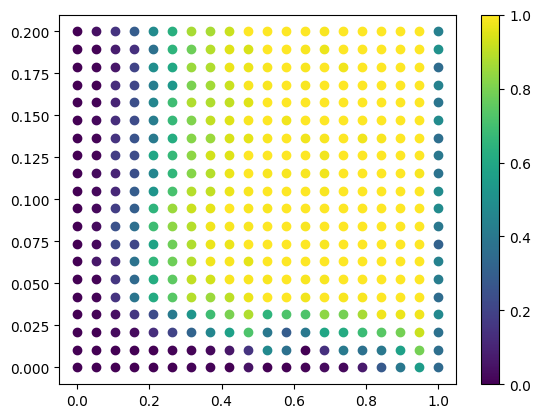

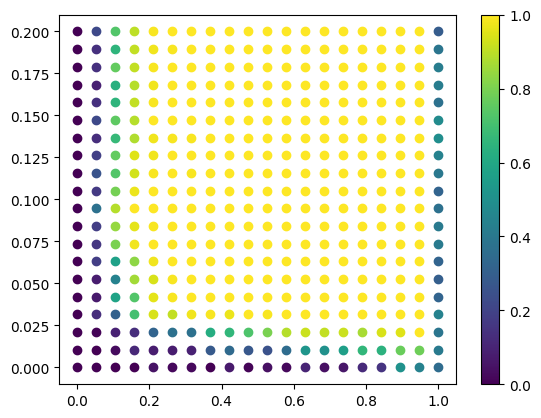

In [ ]:
# 散点1
Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            
            all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_PM_data_{I_tt}_{dtt}_{SNRRR}.npy')
            all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
            
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(all_x_vail_data).reshape(-1,2,2**5)

            y_pre_all=[]
            for i in range(all_x_vail.shape[0]):
                model_NPE.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)



    plt.colorbar()
    plt.show()

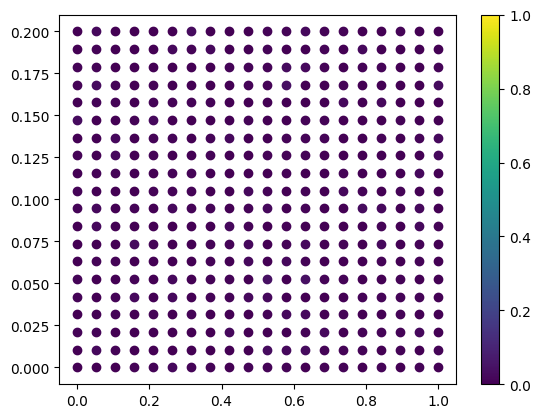

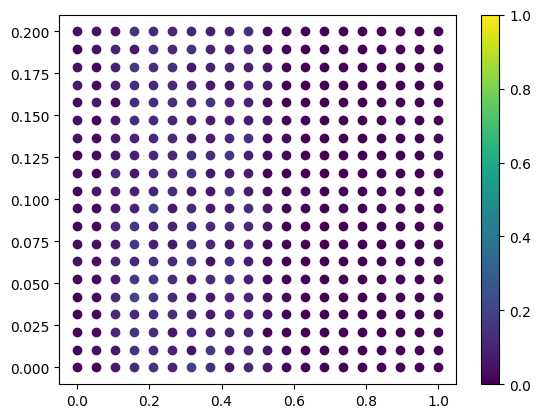

In [19]:
# 散点2
#固定的参数

Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{1}_data_{I_tt}_{dtt}_{SNRRR}.npy')
            all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
            
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(all_x_vail_data).reshape(-1,2,2**5)

            y_pre_all=[]
            for i in range(all_x_vail.shape[0]):
                model_NPE.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)


    plt.colorbar()
    plt.show()

此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像


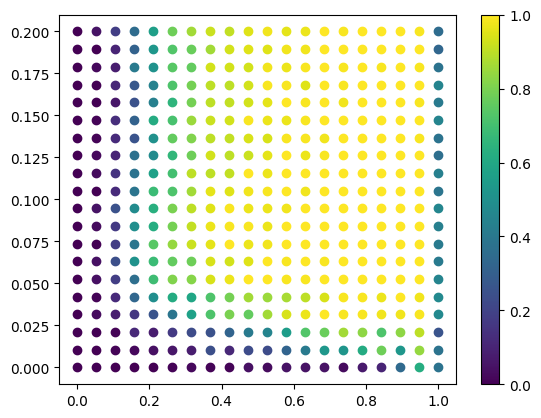

此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像


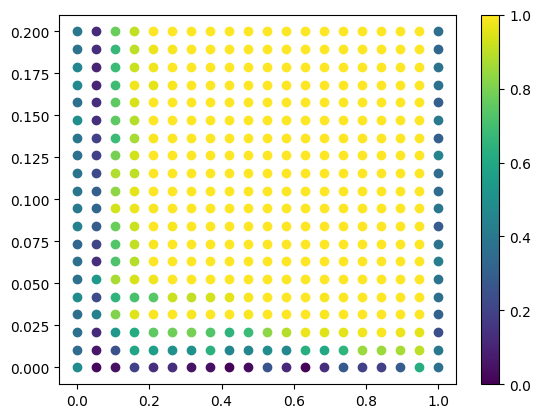

In [20]:

#固定的参数

Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            try:
                all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{2}_data_{I_tt}_{dtt}_{SNRRR}.npy')
                all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
            except:
                print('此条件不可能两个像')
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(all_x_vail_data).reshape(-1,2,2**5)

            y_pre_all=[]
            for i in range(all_x_vail.shape[0]):
                model_NPE.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)



                        
    plt.colorbar()
    plt.show()

此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像


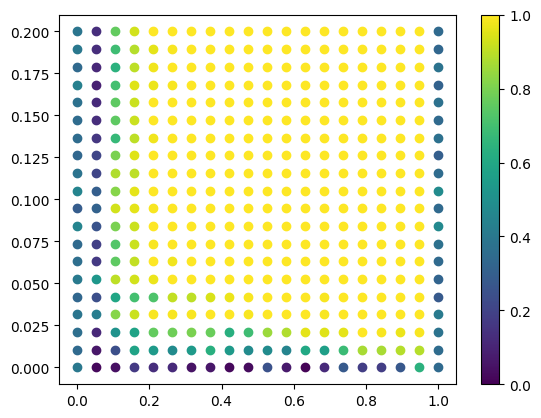

In [21]:

#固定的参数

Z_L=0
for SNRRR in [24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            try:
                all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{2}_data_{I_tt}_{dtt}_{SNRRR}.npy')
                all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
            except:
                print('此条件不可能两个像')
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(all_x_vail_data).reshape(-1,2,2**5)

            y_pre_all=[]
            for i in range(all_x_vail.shape[0]):
                model_NPE.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)



                        
    plt.colorbar()
    plt.show()

# 参数推断合理

In [22]:
import torch

from torch import Tensor
from torch.distributions import Distribution
from tqdm import tqdm
from typing import *
import numpy as np
from lampe.utils import gridapply
#整体p值
def expected_coverage_mc(
    posterior: Callable[[Tensor], Distribution],
    pairs: Iterable[Tuple[Tensor, Tensor]],
    n: int = 1024,
    device: str = None,
) -> Tuple[Tensor, Tensor]:
    ranks = []
    
    theta_d_save=[]
    theta_p_save=[]
    with torch.no_grad():
        for theta, x in tqdm(pairs, unit='pair'):
            #print(theta, x)
            theta_d_save.append(np.array(postprocess(theta.cpu())))
            if device is not None:
                #print(theta, x)
                theta, x = preprocess(theta.reshape((1,2))).to(device), x.to(device).reshape((1,4,40960))#每次需要改探测器数目

            dist = posterior(x)
            samples = dist.sample((n,))
            mask = dist.log_prob(theta) < dist.log_prob(samples)
            rank = mask.sum() / mask.numel()
            
            theta_p_save.append(np.array(postprocess(samples.cpu())))
            ranks.append(rank)
            
    ranks = torch.stack(ranks).cpu()
    ranks = torch.cat((ranks, ranks.new_tensor((0.0, 1.0))))
    return (
        torch.sort(ranks).values,
        torch.linspace(0, 1, len(ranks)),
    ),(theta_d_save,theta_p_save)

In [23]:
from lampe.plots import nice_rc, coverage_plot

100%|██████████| 200/200 [01:23<00:00,  2.39pair/s]


KS statistic: 0.04950495049504951
p-value: 0.9661935243711939


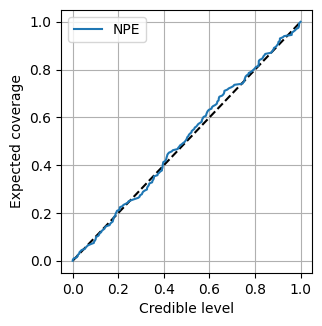

In [24]:
#p值
#加载测试数据
from scipy import stats
for SSRRNN in [24]:
    base_data='/home/DATA/suntianyang/gw_len/data/theta/'
    use_data=f'PM_theta_{SSRRNN}.h5'
    testset=H5Dataset(base_data+use_data)
    #测试
    estimator_NPE.eval()
    prior = zuko.distributions.BoxUniform(LOWER.cuda(), UPPER.cuda())
    (npe_levels, npe_coverages),(theta_save,x_save) = expected_coverage_mc(estimator_NPE.flow, testset, device='cuda')
    
    
    fig = coverage_plot(npe_levels, npe_coverages, legend='NPE')
    observed_cdf = np.sort(npe_levels)
    # theoretical CDF (diagonal line)
    theoretical_cdf = np.linspace(0,1,len(npe_levels))

    # perform KS test
    statistic, p_values = stats.ks_2samp(observed_cdf, theoretical_cdf)
    plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

    print("KS statistic:", statistic)
    print("p-value:", p_values)

In [25]:
1

1

# 参数推断精度

In [31]:
#计算最终要计算的参数的误差
#bnre.cpu()
estimator_NPE.cuda()
def plot_conter(testset,num=0,plot=True,model='NPE',gird=[0]):
    #if num>40:
    #    print('超出范围')
    sample=torch.tensor([])
    if model=='NPE':
        for i in range(num,num+1):
            #x_star,x_data=testset[i+40*(Tk//5-8)+40*(wm-3)*9+gggied*40*9*8]#*10表示只有第一个gird
            x_star,x_data=testset[i]
            #x_data=preprocess_data(x_data)
            estimator_NPE.eval()
            with torch.no_grad():
                samples = estimator_NPE.flow(x_data[np.newaxis,:].cuda()).sample((2**18,)).cpu()
                samples = postprocess(samples)#.reshape((2**16,2)))
                sample=torch.cat([sample,samples], dim=0)

        sample=sample.reshape((-1,2))
    
    if plot==True:
        plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings
        fig = corner(
            sample,
            #labels=LABELS,
            #bins=16,
            smooth=1,
            creds=(0.683, 0.954),
            #domain=([ 2., 50.], [ 10., 70.]),
            #domain=(LOWER, UPPER),
            figsize=(8, 8),
        )

        mark_point(fig, x_star)
    
    
    
    # 假设有一堆数据
    data1 = np.array(sample[:,0])
    data2 = np.array(sample[:,1])
    # 对数据进行排序（虽然期望不用，但是百分位数用）
    sorted_data1 = np.sort(data1)
    sorted_data2 = np.sort(data2)
    # 计算中心值(计算期望比最大概率以及中位数，在没有异常值的时候更合理)
    center_value1 = np.mean(sorted_data1)
    center_value2 = np.mean(sorted_data2)
    # 计算置信区间
    conf_interval_68_1 = np.percentile(sorted_data1, [16, 84])
    conf_interval_95_1 = np.percentile(sorted_data1, [2.3, 97.7])
    
    conf_interval_68_2 = np.percentile(sorted_data2, [16, 84])
    conf_interval_95_2 = np.percentile(sorted_data2, [2.3, 97.7])
    
    #conf_interval_68_1 = Confidence_Range(sorted_data1,0.68)
    #print(conf_interval_68_1)
    #conf_interval_68_2 = Confidence_Range(sorted_data2,0.68)

    #print(conf_interval_68_1)
    
    print(f'真实值：{x_star}')
    print("Wm的中心值:", center_value1)
    print("+σ:", conf_interval_68_1[1]-center_value1)
    print("-σ:", conf_interval_68_1[0]-center_value1)

    print("Tk的中心值:", center_value2)
    print("+σ:", conf_interval_68_2[1]-center_value2)
    print("-σ:", conf_interval_68_2[0]-center_value2)
    
    return sample
    
#real_ping_fortwo_grid()

In [32]:
SSRRNN=32
base_data='/home/DATA/suntianyang/gw_len/data/theta/'
use_data=f'PM_theta_{SSRRNN}.h5'
testset=H5Dataset(base_data+use_data)

真实值：tensor([0.1096, 0.5654])
Wm的中心值: 0.11165268
+σ: 0.0034620314836502075
-σ: -0.0034715086221694946
Tk的中心值: 0.7275494
+σ: 0.14542945384979244
-σ: -0.13941200017929078
真实值：tensor([0.0147, 0.9893])
Wm的中心值: 0.018395526
+σ: 0.00679217979311943
-σ: -0.004172063432633877
Tk的中心值: 0.9784058
+σ: 0.012790522575378382
-σ: -0.011271893978118896
真实值：tensor([0.0525, 0.9231])
Wm的中心值: 0.052950133
+σ: 0.0029197707772254944
-σ: -0.0028594331443309792
Tk的中心值: 0.92023945
+σ: 0.04569043874740597
-σ: -0.045065104961395264
真实值：tensor([0.1906, 0.6769])
Wm的中心值: 0.17603543
+σ: 0.01746233701705932
-σ: -0.0170434147119522
Tk的中心值: 0.73647976
+σ: 0.14139676809310908
-σ: -0.13942894935607908
真实值：tensor([0.1723, 0.7132])
Wm的中心值: 0.17392424
+σ: 0.018669053316116346
-σ: -0.017702581286430347
Tk的中心值: 0.7802527
+σ: 0.11613948106765748
-σ: -0.11838457345962528


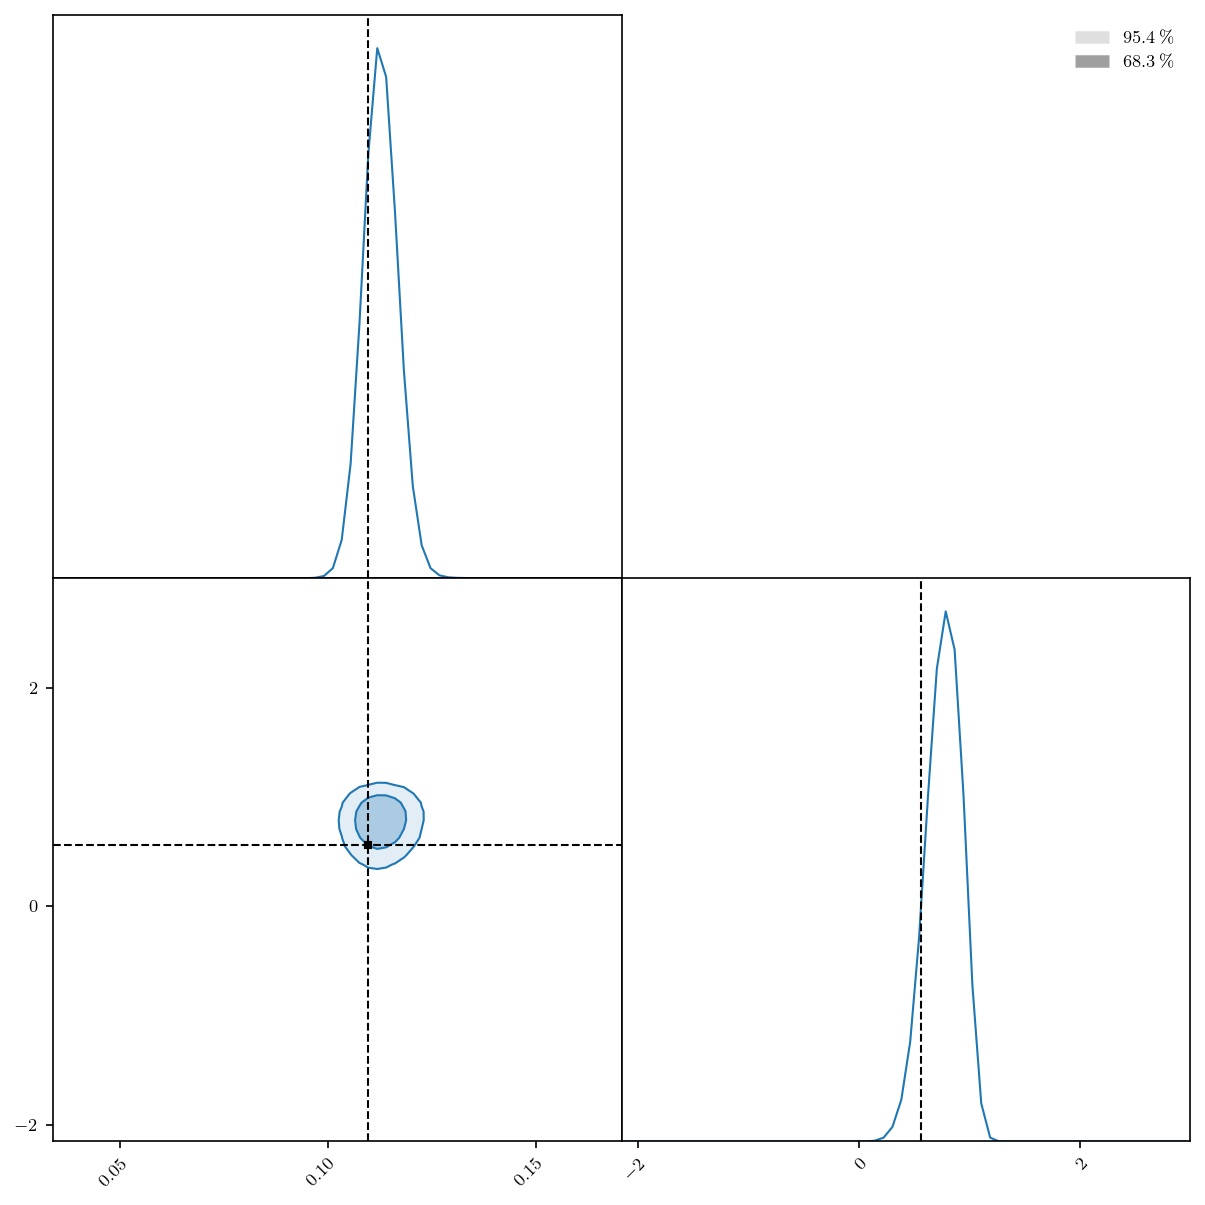

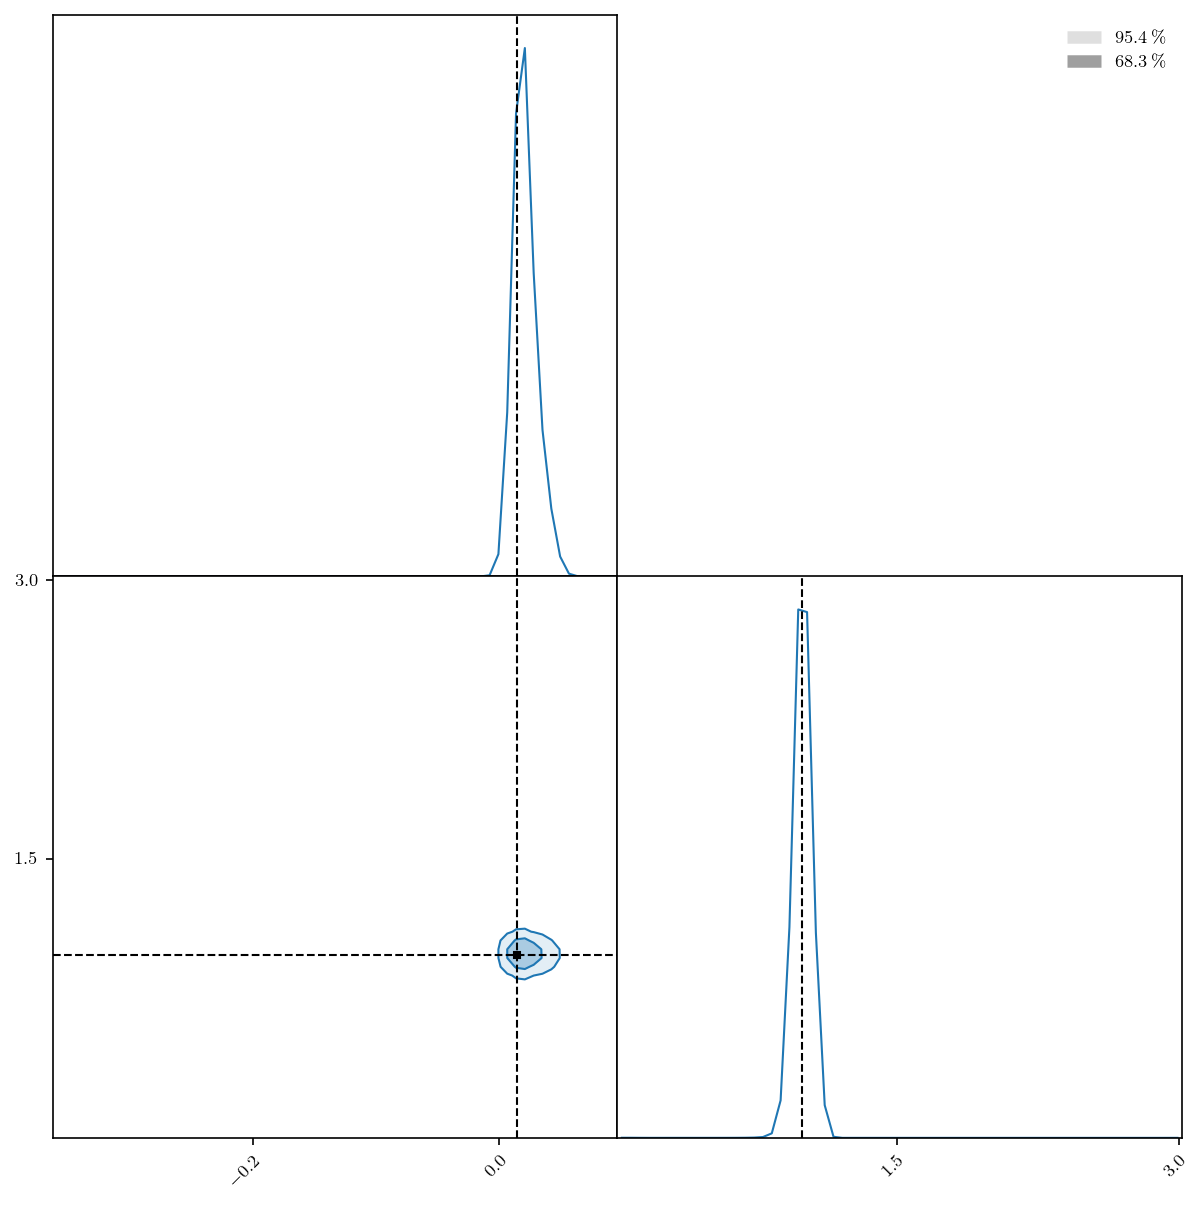

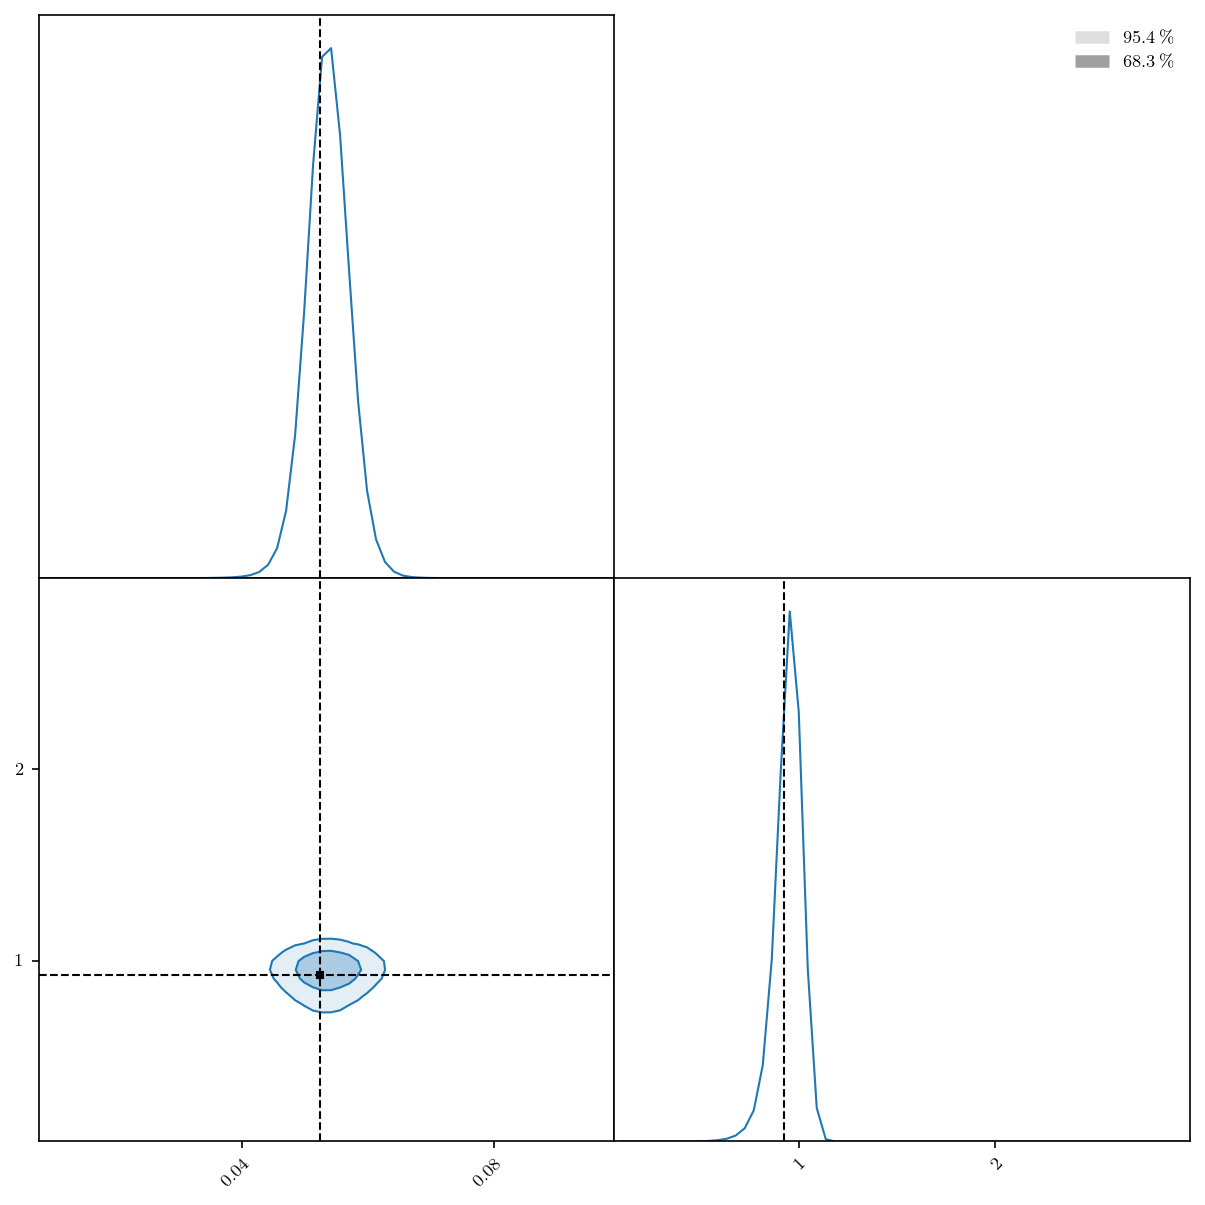

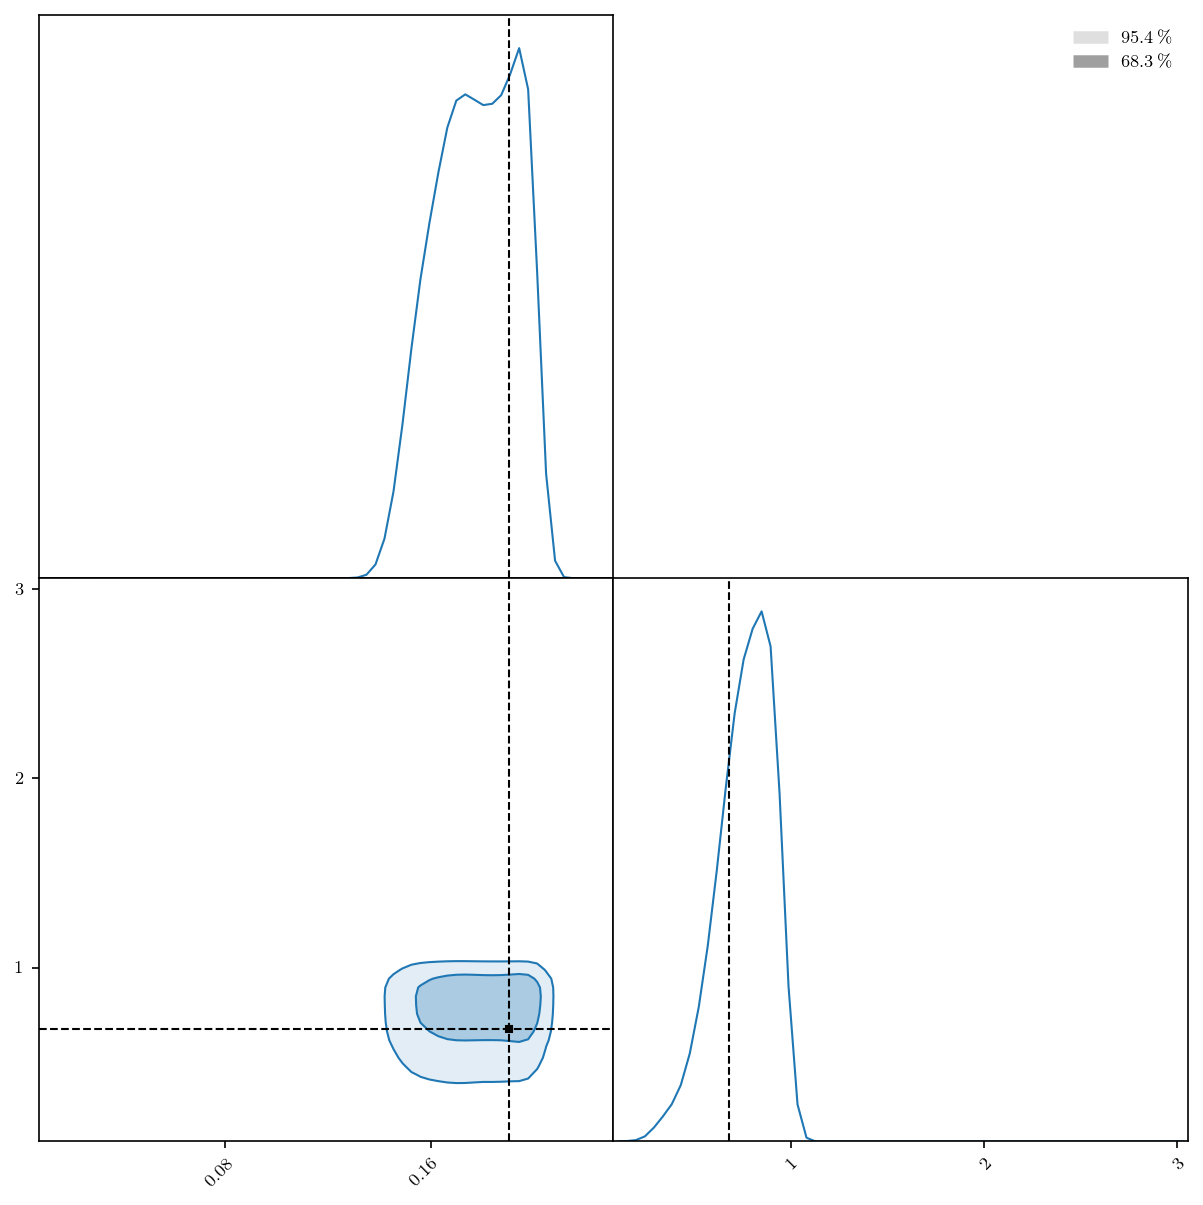

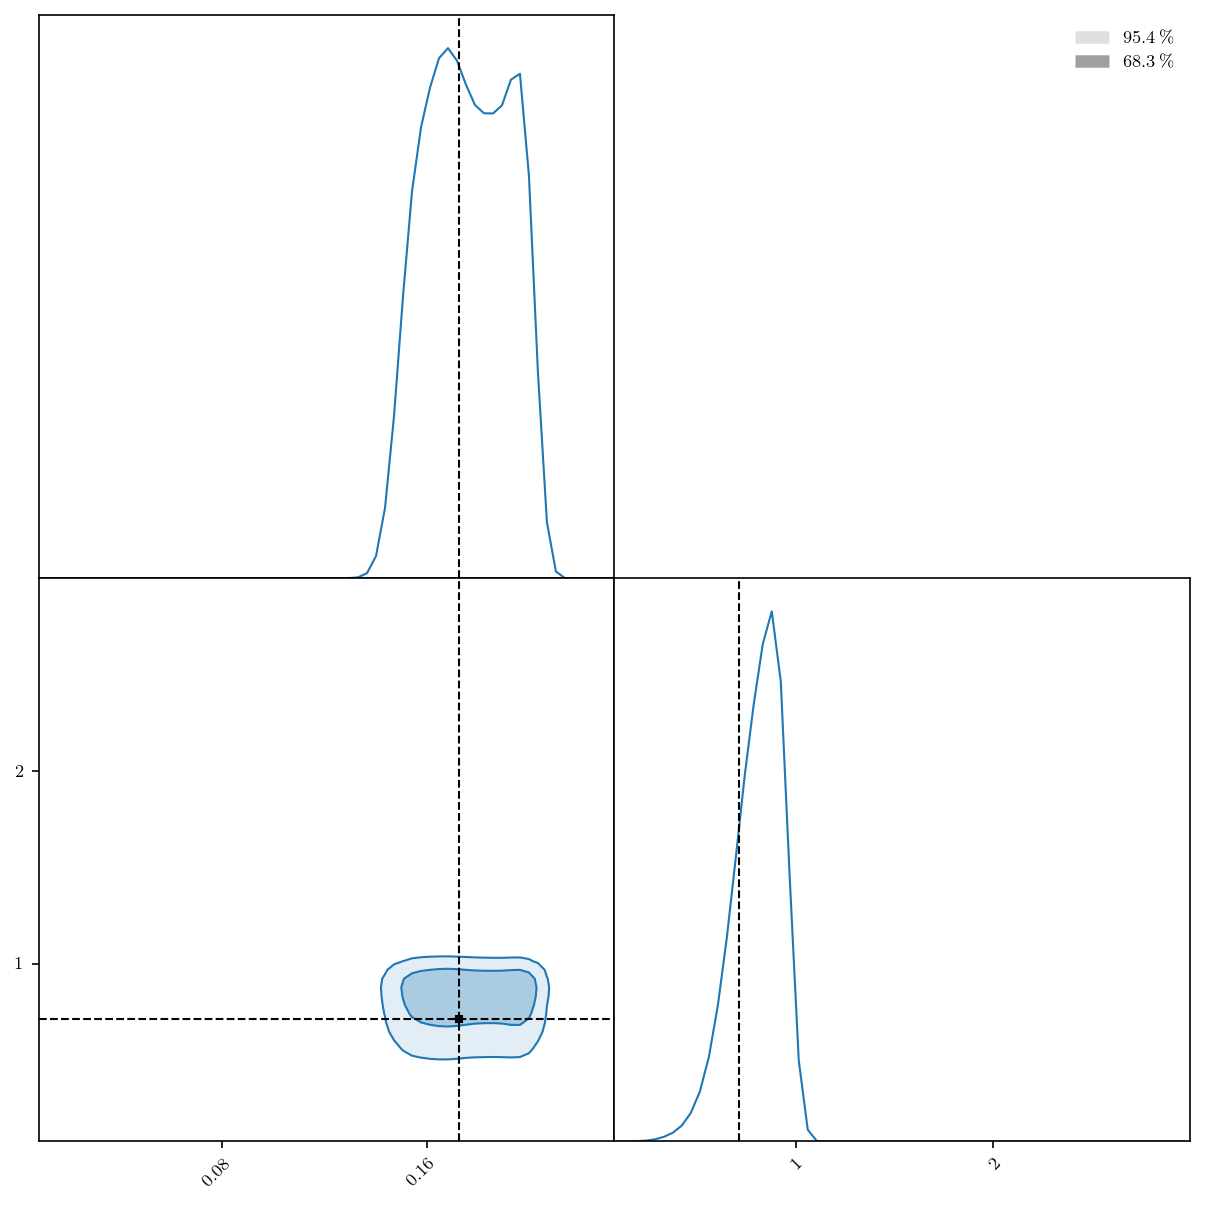

In [33]:
for i in range(0,5):
    plot_conter(testset,i)